# Import basic libraries and dependencies

In [1]:
import sys
import importlib
import sentencepiece as spm
import config

importlib.reload(config)
sys.path.append('./modules')
from config import English, Bengali

# Set a language

In [2]:
LANG = Bengali # English, Bengali

# 1. Data Preparation

In [3]:
# import libraries and dependencies
import preprocessing
importlib.reload(preprocessing)
from preprocessing import raw_preprocess, split_train_test

## 1.1. Preprocess data for sentencepiece

In [4]:
# preprocess raw data to get a list of sentences.
sentences = raw_preprocess(LANG)

# write the sentences into a file, each sentence on one line.
with open(f'data/{LANG.name}_preprocessed.txt', 'w') as f:
    for sentence in sentences:
        f.write(f'{sentence}\n')

## 1.2. Train/test split

In [5]:
# split data to train and test.
train, test = split_train_test(sentences, LANG)

# write train and test data into corresponding files.
train_path = f'data/{LANG.name}_train.txt'
test_path = f'data/{LANG.name}_test.txt'

with open(train_path, 'w') as f:
    f.write('\n'.join(train))
with open(test_path, 'w') as f:
    f.write('\n'.join(test))

# 2. Subword segmentation

We use a small subword vocabulary size of 500 and a large subword vocabulary size of 1500.

In [6]:
# import libraries and dependencies
import segmentation
importlib.reload(segmentation)
from segmentation import train_segmentation, encode_text_file, decode_text_file
from config import seg_profiles

In [7]:
seg_profiles[LANG.name]

[SegmentationConf(id='s1', vocab_size=None, model_type='char'),
 SegmentationConf(id='s2', vocab_size=800, model_type='bpe'),
 SegmentationConf(id='s3', vocab_size=1700, model_type='bpe')]

In [12]:
for seg in seg_profiles[LANG.name]:
    # train segmentation on the train data
    spm1 = train_segmentation(
        text_file=train_path, 
        LANG=LANG, 
        vocab_size=seg.vocab_size, 
        model_type=seg.model_type)
  
    encoded_file = f'data/{LANG.name}_{seg.id}.txt'
    encode_text_file(text_file=train_path, model_path=spm1, output_file=encoded_file)
    
    decoded_file = f'data/{LANG.name}_{seg.id}_decoded.txt'
    decode_text_file(text_file=encoded_file, model_path=spm1, output_file=decoded_file)
    
    # test it on the test data
    encoded_file = f'data/{LANG.name}_{seg.id}_test.txt'
    encode_text_file(text_file=test_path, model_path=spm1, output_file=encoded_file)
    
    decoded_file = f'data/{LANG.name}_{seg.id}_decoded_test.txt'
    decode_text_file(text_file=encoded_file, model_path=spm1, output_file=decoded_file)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/bn_train.txt
  input_format: 
  model_prefix: ./seg_models/spm_bn_char
  model_type: CHAR
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespa

# 3. Language Model

## Baseline

In [13]:
from config import baseline_conf
baseline_conf

TrainingConf(hidden=40, rand_seed=1, debug=2, bptt=4, n_class=9999)

In [14]:
for seg in seg_profiles[LANG.name]:
    # Hyper parameters
    hidden = baseline_conf.hidden
    rand_seed = baseline_conf.rand_seed
    debug = baseline_conf.debug
    bptt = baseline_conf.bptt
    n_class = baseline_conf.n_class

    # Parameters
    model_path = f'models/rnnlm/{LANG.name}_{seg.id}_baseline'
    train_path = f'../../../data/{LANG.name}_{seg.id}.txt'
    valid_path = f'../../../data/{LANG.name}_{seg.id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $n_class
    
    # read output and print perplexity
    with open(f'{model_path}/model.output.txt', 'r') as f:
        output = f.read()
        pp = output.split()[-1]
        print(f'Baseline {LANG.name}-{seg.id} validation perplexity: {pp}')

debug mode: 2
train file: ../../../data/bn_s1.txt
valid file: ../../../data/bn_s1_test.txt
class size: 9999
Hidden layer size: 40
BPTT: 4
Rand seed: 1
rnnlm file: model
Starting training using file ../../../data/bn_s1.txt
Vocab size: 306
Words in train file: 1113598
Iter:   0	Alpha: 0.100000	   TRAIN entropy: 3.2145    Progress: 84.41%   Words/sec: 1057.1 ^C


FileNotFoundError: [Errno 2] No such file or directory: 'models/rnnlm/bn_s1_baseline/model.output.txt'

## Experiments

In [3]:
import pickle
import itertools

In [6]:
# experimented results are kept in a file
grid_result_file = f'experiments/{LANG.name}_task3_grid_search.pickle'
# grid_results stores the results in memory
grid_results = {}

# import previous results if exists
try:
    with open(grid_result_file, 'rb') as f:
        previous_results = pickle.load(f)
        grid_results.update(previous_results)
except:
    pass #TODO: add exceptions etc.

print(grid_results[0:5])

{('en', 's1', 5, 0, 10): 10.887227, ('en', 's1', 5, 0, 100): 10.645946, ('en', 's1', 5, 0, 1501): 10.482386, ('en', 's1', 5, 1, 10): 10.605196, ('en', 's1', 5, 1, 100): 10.271953, ('en', 's1', 5, 1, 1501): 10.261143, ('en', 's1', 5, 3, 10): 10.650879, ('en', 's1', 5, 3, 100): 10.273488, ('en', 's1', 5, 3, 1501): 10.1756, ('en', 's1', 5, 5, 10): 10.650509, ('en', 's1', 5, 5, 100): 10.275037, ('en', 's1', 5, 5, 1501): 10.170872, ('en', 's1', 20, 0, 10): 7.372125, ('en', 's1', 20, 0, 100): 6.910608, ('en', 's1', 20, 0, 1501): 7.039472, ('en', 's1', 20, 1, 10): 6.759173, ('en', 's1', 20, 1, 100): 6.477795, ('en', 's1', 20, 1, 1501): 6.552387, ('en', 's1', 20, 3, 10): 6.617757, ('en', 's1', 20, 3, 100): 6.550642, ('en', 's1', 20, 3, 1501): 6.441925, ('en', 's1', 20, 5, 10): 6.675042, ('en', 's1', 20, 5, 100): 6.571401, ('en', 's1', 20, 5, 1501): 6.611228, ('en', 's1', 40, 0, 10): 6.051518, ('en', 's1', 40, 0, 100): 5.971961, ('en', 's1', 40, 0, 1501): 5.99838, ('en', 's1', 40, 1, 10): 5.437

In [ ]:
hidden_choices = [5, 20, 40, 70, 100, 150, 200]
bptt_choices = [0, 1, 3, 5]
class_choices = [10, 100, 1501]
rand_seed = 1
debug = 2

for seg, hidden, bptt, _class in itertools.product(
    seg_profiles[LANG.name], hidden_choices, bptt_choices, class_choices):

    if (LANG.name, seg.id, hidden, bptt, _class) in grid_results:
        print(f'skip {LANG.name} {seg.id} {hidden} {bptt} {_class}')
        continue

    # Parameters
    model_path = f'models/rnnlm/{LANG.name}_{seg.id}'
    train_path = f'../../../data/{LANG.name}_{seg.id}.txt'
    valid_path = f'../../../data/{LANG.name}_{seg.id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $_class \
        2> error.txt

    # read output extract validation perplexity
    with open(f'{model_path}/model.output.txt', 'r') as f:
        output = f.read()
        pp = float(output.split()[-1])
        grid_results[(LANG.name, seg.id, hidden, bptt, _class)] = pp

    # write current results to file
    with open(grid_result_file, 'wb') as f:
        pickle.dump(grid_results, f)

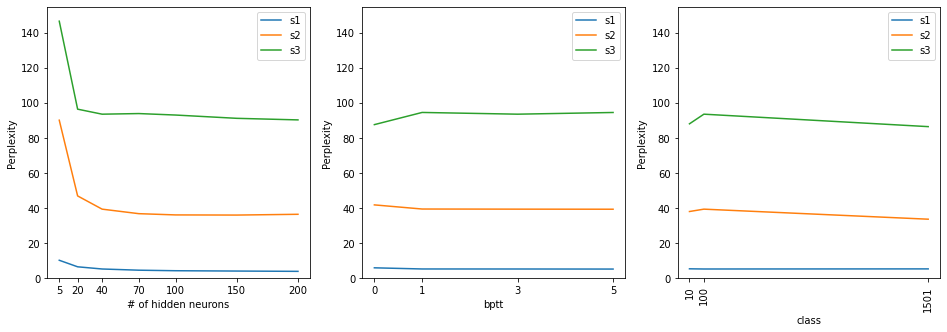

In [28]:
import visualization 
visualization = importlib.reload(visualization)

visualization.plot_grid_results(grid_results)

The optimal configurations of hyperparameters for each vocabulary size are:

In [12]:
for seg in seg_profiles:
    results = dict((k, v) for (k, v) in grid_results.items() if k[1] == seg.id)
    print(f"{seg.id}: {min(results, key=results.get)}")


s1: ('en', 's1', 200, 3, 100)
s2: ('en', 's2', 200, 3, 1501)
s3: ('en', 's3', 40, 0, 1501)
